# 0 Script for the SynMall Feature Extraction Module Analysis

This script is used to visualize the content related to Figure 2 in the SynMall manuscript.

# 1 DNA level features

## 1.1 DNAShape

1. The 17th feature of EP

In [4]:
import pandas as pd

# Specify the path to the FASTA file
def retrieve_from_dnashaper(fasta_file):
    wlist = ["EP", "HelT", "MGW", "ProT", "Roll"]

    results = []
    for dtype in wlist:
        feature_dict = {}
        with open(f"{fasta_file}{dtype}", 'r') as f:
            lines = f.read().split('>')  # Manually split FASTA entries

            for entry in lines:
                if not entry.strip():
                    continue
                header, *seq_lines = entry.strip().split('\n')
                # Concatenate while preserving correct comma separation
                seq_str = ''.join(seq_lines).replace('\n', '').replace('\r', '')
                seq_str = ','.join(','.join(seq_lines).split(','))  # Safety measure
                feature_dict[header] = seq_str

        # Convert to list (maintaining original order)
        feature_list = list(feature_dict.values())
        results.append(feature_list)

    # Construct DataFrame
    return pd.DataFrame(results, index=wlist).T

In [ ]:
pos_path = ".../Data/Features/visualization_demo/Data/Features/visualization_demo/DNA_train_pos/DNA_Structure_Features_DNAshapeR/bedtool_alternate.fasta."
result_df_pos = retrieve_from_dnashaper(pos_path)

In [ ]:
neg_path = "../Data/Features/visualization_demo/DNA_train_neg/DNA_Structure_Features_DNAshapeR/bedtool_alternate.fasta."
result_df_neg = retrieve_from_dnashaper(neg_path)

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ks_2samp

def parse_feature_to_array(seq_str, target_len=33):
    vals = [float(x) if x != 'NA' else np.nan for x in seq_str.split(',')]
    vals = vals[:target_len]
    if len(vals) < target_len:
        vals += [np.nan] * (target_len - len(vals))
    return np.array(vals, dtype=np.float32)

def extract_single_feature(df, feature_name):
    feature_list = []
    for _, row in df.iterrows():
        feature_list.append(parse_feature_to_array(row[feature_name]))
    return np.vstack(feature_list)

def effect_size_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    if s_pooled == 0:
        return np.nan
    return (np.nanmean(x1) - np.nanmean(x2)) / s_pooled

# Thresholds: p-value (controls distribution difference) and d-value (ensures robustness regardless of sample size)
p_thresh = 0.05
d_thresh = 0.5

feature_names = ['EP', 'HelT', 'MGW', 'ProT', 'Roll']
results = []

for feat in feature_names:
    feat_pos = extract_single_feature(result_df_pos, feat)
    feat_neg = extract_single_feature(result_df_neg, feat)
    
    for i in range(feat_pos.shape[1]):
        pos_col = feat_pos[:, i]
        neg_col = feat_neg[:, i]
        
        pos_col_clean = pos_col[~np.isnan(pos_col)]
        neg_col_clean = neg_col[~np.isnan(neg_col)]
        
        if len(pos_col_clean) < 2 or len(neg_col_clean) < 2:
            continue
        
        t_stat, p_val = ttest_ind(pos_col_clean, neg_col_clean, equal_var=False, nan_policy='omit')
        ks_stat, ks_p = ks_2samp(pos_col_clean, neg_col_clean)
        d = effect_size_d(pos_col_clean, neg_col_clean)
        
        if (p_val < p_thresh) and (abs(d) > d_thresh):
            results.append({
                'Feature': feat,
                'Dimension': i + 1,
                't_stat': round(t_stat, 3),
                'p_val': p_val,
                'KS_stat': round(ks_stat, 3),
                'KS_p': ks_p,
                'Effect_d': round(d, 3)
            })

# Output as DataFrame
sig_df = pd.DataFrame(results)
print(sig_df)

  Feature  Dimension  t_stat         p_val  KS_stat          KS_p  Effect_d
0      EP         17 -13.239  2.018665e-38    0.221  4.440892e-16    -0.554


### KDE visualization

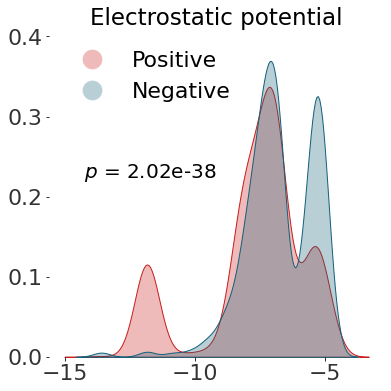

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

# 1 Set fonts
fontsize = 22
font = FontProperties(size=fontsize, weight='light')
black_font_color = '#333'

# 2 Prepare data
# EP's 17th dimension (note: Python uses 0-based indexing)
dim_idx = 16  # 17th dimension -> index 16
# Extract positive and negative sample data
feat_pos_ep = extract_single_feature(result_df_pos, 'EP')[:, dim_idx]
feat_neg_ep = extract_single_feature(result_df_neg, 'EP')[:, dim_idx]
# Remove NA values
pos_clean = feat_pos_ep[~np.isnan(feat_pos_ep)]
neg_clean = feat_neg_ep[~np.isnan(feat_neg_ep)]
# p-value
p_value = 2.018665e-38
p_value_text = f"$p$ = {p_value:.2e}"  # Italic p

# 3 KDE visualization
# Create plot
colors = ['#c71e1d', '#15607a']
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(pos_clean, label='Positive', color=colors[0], fill=True, alpha=0.3)
sns.kdeplot(neg_clean, label='Negative', color=colors[1], fill=True, alpha=0.3)
# Set title
ax.set_title('Electrostatic potential', fontsize=fontsize + 1)
# Set x, y label and tick fonts
ax.tick_params(axis='x', labelsize=font.get_size(),
               labelcolor=black_font_color)
ax.tick_params(axis='y', labelsize=font.get_size(),
               labelcolor=black_font_color)
# Remove y-axis label
ax.set_ylabel('')
# Adjust y-axis limit to ensure highest tick is fully displayed
ax.set_ylim(top=ax.get_ylim()[1]*1.05)  # Add 5% top margin
# Add p-value
ax.text(x=0.5, y=0.6, s=p_value_text, 
        transform=ax.transAxes,  # Use axis relative position
        ha='right', va='top',    # Right-align, top-align
        fontsize=fontsize-2,     # Slightly smaller than title
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))  # Semi-transparent white background
# Remove borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# Custom legend
simple_legend_labels = ["Positive", "Negative"]
custom_lines = [Line2D([0], [0], 
                marker='o', 
                color='w', 
                markerfacecolor=color, 
                markersize=20, 
                linestyle='',
                alpha=0.3) 
                for color in colors]
legend = plt.legend(custom_lines, 
          simple_legend_labels, 
          bbox_to_anchor=[0.6, 1], 
          frameon=False, 
          labelspacing=0.5,
          prop=font)
fig.savefig("../Data/Features/visualization_demo/_plot_result/dna_structure_ep.jpg", dpi=300, bbox_inches='tight')
plt.show()

### CDF visualization

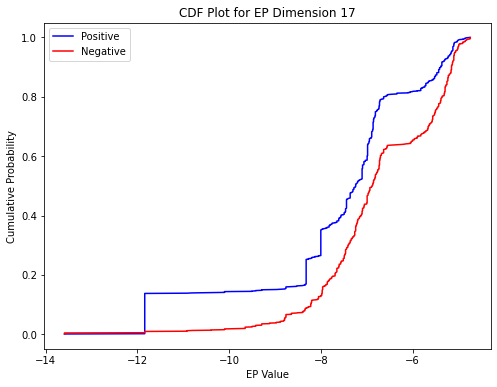

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x_pos, y_pos = ecdf(pos_clean)
x_neg, y_neg = ecdf(neg_clean)

plt.figure(figsize=(8, 6))
plt.plot(x_pos, y_pos, label='Positive', color='blue')
plt.plot(x_neg, y_neg, label='Negative', color='red')
plt.title('CDF Plot for EP Dimension 17')
plt.xlabel('EP Value')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

## 1.2 DNA sequence

In [ ]:
import pandas as pd
dna_sequence_pos = pd.read_csv("../Data/Features/visualization_demo/DNA_train_pos/Sequence_Features_ifeatureOmega/iFeatureOmega_DNA_alternate.txt", sep='\t')
dna_sequence_pos['label'] = [1] * len(dna_sequence_pos)
dna_sequence_neg = pd.read_csv("../Data/Features/visualization_demo/DNA_train_neg/Sequence_Features_ifeatureOmega/iFeatureOmega_DNA_alternate.txt", sep='\t')
dna_sequence_neg['label'] = [0] * len(dna_sequence_neg)
dna_sequence = pd.concat([dna_sequence_pos, dna_sequence_neg], ignore_index=True)

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ks_2samp
from tqdm import tqdm

def effect_size_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    if s_pooled == 0:
        return np.nan
    return (np.nanmean(x1) - np.nanmean(x2)) / s_pooled

def analyze_features(df, label_col, p_thresh=0.05, d_thresh=0.5):
    pos_df = df[df[label_col] == 1]
    neg_df = df[df[label_col] == 0]
    
    feature_cols = [col for col in df.columns if col != label_col]
    results = []
    
    for feat in tqdm(feature_cols):
        pos_vals = pos_df[feat].dropna().values
        neg_vals = neg_df[feat].dropna().values
        
        if len(pos_vals) < 2 or len(neg_vals) < 2:
            continue
        
        t_stat, p_val = ttest_ind(pos_vals, neg_vals, equal_var=False, nan_policy='omit')
        ks_stat, ks_p = ks_2samp(pos_vals, neg_vals)
        d = effect_size_d(pos_vals, neg_vals)
        print(f"feat: {feat} \t p_val {p_val} \t KS_p {ks_p}")
        if (p_val < p_thresh) and (abs(d) > d_thresh):
            results.append({
                'Feature': feat,
                't_stat': round(t_stat, 3),
                'p_val': p_val,
                'KS_stat': round(ks_stat, 3),
                'KS_p': ks_p,
                'Effect_d': round(d, 3)
            })
    
    return pd.DataFrame(results)

In [11]:
result_df = analyze_features(dna_sequence, label_col='label', p_thresh=0.05, d_thresh=0.4)
print(result_df)

  3%|▎         | 52/1904 [00:00<00:07, 257.63it/s]

feat: Kmer_AAA 	 p_val 0.0016798842873512556 	 KS_p 0.06940638915711465
feat: Kmer_AAC 	 p_val 0.5793145325811855 	 KS_p 0.9999148469091048
feat: Kmer_AAG 	 p_val 0.005139035102430599 	 KS_p 0.30707986361156997
feat: Kmer_AAT 	 p_val 0.9000428635239556 	 KS_p 0.9958537857220333
feat: Kmer_ACA 	 p_val 0.0862579126395381 	 KS_p 0.6429979302543614
feat: Kmer_ACC 	 p_val 0.30401191910008823 	 KS_p 0.5073327865839171
feat: Kmer_ACG 	 p_val 0.020370791831222736 	 KS_p 0.30707986361156997
feat: Kmer_ACT 	 p_val 4.521216302899868e-15 	 KS_p 5.5167672528643824e-12
feat: Kmer_AGA 	 p_val 0.8094517310643788 	 KS_p 1.0
feat: Kmer_AGC 	 p_val 0.4517148003448558 	 KS_p 1.0
feat: Kmer_AGG 	 p_val 0.0013182422302138452 	 KS_p 0.1276999671789401
feat: Kmer_AGT 	 p_val 3.5088686435808226e-13 	 KS_p 5.5167672528643824e-12
feat: Kmer_ATA 	 p_val 0.48262014358516303 	 KS_p 0.9997048316922376
feat: Kmer_ATC 	 p_val 0.014627833672820464 	 KS_p 0.0623270873334954
feat: Kmer_ATG 	 p_val 0.8619831020344336 	 KS

  5%|▍         | 86/1904 [00:00<00:06, 284.55it/s]

feat: Kmer_TCA 	 p_val 0.29177008880645533 	 KS_p 0.7121579083158075
feat: Kmer_TCC 	 p_val 0.009611089463827585 	 KS_p 0.5403309805375461
feat: Kmer_TCG 	 p_val 3.1830146674906594e-05 	 KS_p 0.01706112443215594
feat: Kmer_TCT 	 p_val 0.43419355816879934 	 KS_p 0.9999811731837679
feat: Kmer_TGA 	 p_val 0.6749547323398861 	 KS_p 0.9997048316922376
feat: Kmer_TGC 	 p_val 0.022849485502413714 	 KS_p 0.28356522744194035
feat: Kmer_TGG 	 p_val 0.26796014861381257 	 KS_p 0.9922163376710178
feat: Kmer_TGT 	 p_val 0.409347572956407 	 KS_p 0.779069452721068
feat: Kmer_TTA 	 p_val 0.0005946071749284509 	 KS_p 0.005843756637046012
feat: Kmer_TTC 	 p_val 0.26332646951365235 	 KS_p 0.8944232395030779
feat: Kmer_TTG 	 p_val 0.6976279134986381 	 KS_p 1.0
feat: Kmer_TTT 	 p_val 0.005655697637555071 	 KS_p 0.24046651916126327
feat: Kmer_AAA.1 	 p_val 0.0016798842873512524 	 KS_p 0.06940638915711465
feat: Kmer_AAC.1 	 p_val 0.5793145325811859 	 KS_p 0.9999148469091048
feat: Kmer_AAG.1 	 p_val 0.00513903

  8%|▊         | 144/1904 [00:00<00:06, 279.02it/s]


feat: Kmer_TAC.1 	 p_val 3.5455023148304436e-07 	 KS_p 3.2849953546680137e-05
feat: Kmer_TAG.1 	 p_val 0.14413400194449352 	 KS_p 0.9958537857220333
feat: Kmer_TAT.1 	 p_val 0.32790686443084816 	 KS_p 0.9999148469091048
feat: Kmer_TCA.1 	 p_val 0.2917700888064563 	 KS_p 0.7121579083158075
feat: Kmer_TCC.1 	 p_val 0.009611089463827566 	 KS_p 0.5403309805375461
feat: Kmer_TCG.1 	 p_val 3.183014667490666e-05 	 KS_p 0.01706112443215594
feat: Kmer_TCT.1 	 p_val 0.4341935581687981 	 KS_p 0.9999811731837679
feat: Kmer_TGA.1 	 p_val 0.6749547323398881 	 KS_p 0.9997048316922376
feat: Kmer_TGC.1 	 p_val 0.02284948550241342 	 KS_p 0.28356522744194035
feat: Kmer_TGG.1 	 p_val 0.2679601486138117 	 KS_p 0.9922163376710178
feat: Kmer_TGT.1 	 p_val 0.4093475729564038 	 KS_p 0.779069452721068
feat: Kmer_TTA.1 	 p_val 0.0005946071749284522 	 KS_p 0.005843756637046012
feat: Kmer_TTC.1 	 p_val 0.26332646951365235 	 KS_p 0.8944232395030779
feat: Kmer_TTG.1 	 p_val 0.6976279134986341 	 KS_p 1.0
feat: Kmer_

 10%|█         | 198/1904 [00:00<00:06, 247.81it/s]

feat: AAA.1 	 p_val 4.569275762753753e-05 	 KS_p 0.03153817745380692
feat: AAC.1 	 p_val 0.617365360808867 	 KS_p 0.9999999844063459
feat: AAG.1 	 p_val 0.0001493939911649951 	 KS_p 0.0500052899533585
feat: AAT.1 	 p_val 0.7358249874821936 	 KS_p 0.9541175019297167
feat: ACA.1 	 p_val 0.061721339089722924 	 KS_p 0.4752384981100359
feat: ACC.1 	 p_val 0.003822117040876169 	 KS_p 0.004395182003919519
feat: ACG.1 	 p_val 0.0005613123404533243 	 KS_p 0.008845536498181525
feat: ACT.1 	 p_val 1.454598515324549e-29 	 KS_p 1.7449088919472607e-19
feat: AGA.1 	 p_val 0.4344231570993663 	 KS_p 0.9922163376710178
feat: AGC.1 	 p_val 0.03491924002409794 	 KS_p 0.3855286603659131
feat: AGG.1 	 p_val 3.409200531001819e-05 	 KS_p 0.00771706494064693
feat: ATA.1 	 p_val 0.3312734859597918 	 KS_p 0.998016711100897
feat: ATC.1 	 p_val 0.032453252276452224 	 KS_p 0.18527270631264364
feat: ATG.1 	 p_val 0.4171684410955925 	 KS_p 0.9958537857220333
feat: CAA.1 	 p_val 0.4085391887219266 	 KS_p 0.99991484690

 14%|█▍        | 266/1904 [00:00<00:05, 296.39it/s]


feat: ANF_20 	 p_val 0.15906377667559327 	 KS_p 0.3580734293156795
feat: ANF_21 	 p_val 0.5126828414727024 	 KS_p 0.41424784652443813
feat: ANF_22 	 p_val 0.9369633388782763 	 KS_p 0.9922163376710178
feat: ANF_23 	 p_val 0.5037372822032851 	 KS_p 0.8688270515299285
feat: ANF_24 	 p_val 0.866157408640785 	 KS_p 0.8944232395030779
feat: ANF_25 	 p_val 0.48086492974415873 	 KS_p 0.4752384981100359
feat: ANF_26 	 p_val 0.4542576697674241 	 KS_p 0.3580734293156795
feat: ANF_27 	 p_val 0.07252088706510532 	 KS_p 0.779069452721068
feat: ANF_28 	 p_val 0.553848784406213 	 KS_p 0.6776917037603288
feat: ANF_29 	 p_val 0.4558345934600916 	 KS_p 0.24046651916126327
feat: ANF_30 	 p_val 0.041975944581722616 	 KS_p 0.0771583720785603
feat: ANF_31 	 p_val 0.7316777186377412 	 KS_p 0.8944232395030779
feat: ANF_32 	 p_val 0.8539609945459422 	 KS_p 0.8107843830115652
feat: ANF_33 	 p_val 0.03689635923007851 	 KS_p 0.16925263215021583
feat: CKSNAP_AA.gap0 	 p_val 0.008840233423742643 	 KS_p 0.1852727063

 18%|█▊        | 345/1904 [00:01<00:04, 343.06it/s]

feat: CKSNAP_CT.gap0.1 	 p_val 0.4242507947355486 	 KS_p 0.9678718426894253
feat: CKSNAP_GA.gap0.1 	 p_val 0.09890738749251246 	 KS_p 0.5403309805375461
feat: CKSNAP_GC.gap0.1 	 p_val 0.00011790782298423651 	 KS_p 0.024792429305117315
feat: CKSNAP_GG.gap0.1 	 p_val 0.021214587861041873 	 KS_p 0.05587474771690945
feat: CKSNAP_GT.gap0.1 	 p_val 0.07912104071692239 	 KS_p 0.28356522744194035
feat: CKSNAP_TA.gap0.1 	 p_val 1.0392625909125503e-06 	 KS_p 0.002830488350819667
feat: CKSNAP_TC.gap0.1 	 p_val 0.011334550950557515 	 KS_p 0.1276999671789401
feat: CKSNAP_TG.gap0.1 	 p_val 0.2626177284304568 	 KS_p 0.8688270515299285
feat: CKSNAP_TT.gap0.1 	 p_val 0.017681225001114586 	 KS_p 0.41424784652443813
feat: CKSNAP_AA.gap1.1 	 p_val 0.007542002398764905 	 KS_p 0.08563023465435345
feat: CKSNAP_AC.gap1.1 	 p_val 0.015283835509423511 	 KS_p 0.20245450830932962
feat: CKSNAP_AG.gap1.1 	 p_val 0.28970474325886314 	 KS_p 0.9541175019297167
feat: CKSNAP_AT.gap1.1 	 p_val 4.672271361516601e-16 	 KS_

 22%|██▏       | 420/1904 [00:01<00:04, 347.39it/s]

feat: NCP_27 	 p_val 0.21716301472083674 	 KS_p 0.8408296187952191
feat: NCP_28 	 p_val 0.18496463141705505 	 KS_p 0.779069452721068
feat: NCP_29 	 p_val 0.9344226045979265 	 KS_p 1.0
feat: NCP_30 	 p_val 0.6795058154316505 	 KS_p 0.9999999999976126
feat: NCP_31 	 p_val 0.24714698487025794 	 KS_p 0.8944232395030779
feat: NCP_32 	 p_val 0.17340457265184656 	 KS_p 0.746068900570156
feat: NCP_33 	 p_val 0.0757622185643666 	 KS_p 0.41424784652443813
feat: NCP_34 	 p_val 7.61908866353693e-05 	 KS_p 0.0008122422858071462
feat: NCP_35 	 p_val 5.573231225244243e-06 	 KS_p 7.02874255702977e-05
feat: NCP_36 	 p_val 7.461777271184723e-07 	 KS_p 9.971395239028377e-06
feat: NCP_37 	 p_val 0.10277722486949753 	 KS_p 0.5403309805375461
feat: NCP_38 	 p_val 0.004501934470673983 	 KS_p 0.03548039205610625
feat: NCP_39 	 p_val 2.0909925790518396e-09 	 KS_p 4.5701528688219553e-08
feat: NCP_40 	 p_val 3.0138525527454018e-05 	 KS_p 0.0004944947720351556
feat: NCP_41 	 p_val 0.32130665304914213 	 KS_p 0.967

 26%|██▌       | 488/1904 [00:01<00:04, 311.96it/s]

feat: NCP_85 	 p_val 0.9015840125128572 	 KS_p 1.0
feat: NCP_86 	 p_val 0.8370112266738623 	 KS_p 1.0
feat: NCP_87 	 p_val 0.2474507179939581 	 KS_p 0.8944232395030779
feat: NCP_88 	 p_val 0.20046458072917991 	 KS_p 0.8107843830115652
feat: NCP_89 	 p_val 0.26631988164709874 	 KS_p 0.9173115115102849
feat: NCP_90 	 p_val 0.5101586919699248 	 KS_p 0.9999148469091048
feat: NCP_91 	 p_val 0.3426373763258008 	 KS_p 0.9786267109690271
feat: NCP_92 	 p_val 0.07679189565720813 	 KS_p 0.41424784652443813
feat: NCP_93 	 p_val 0.5646045213553932 	 KS_p 0.9999970539056646
feat: NCP_94 	 p_val 0.4590389792869608 	 KS_p 0.9991690685520457
feat: NCP_95 	 p_val 0.537060789427916 	 KS_p 0.9999811731837679
feat: NCP_96 	 p_val 0.062381897225689646 	 KS_p 0.3580734293156795
feat: NCP_97 	 p_val 0.06387368239905519 	 KS_p 0.3580734293156795
feat: NCP_98 	 p_val 0.005809640400864988 	 KS_p 0.04467639699075769
feat: NCP_99 	 p_val 0.40994588161507983 	 KS_p 0.9958537857220333
feat: EIIP_1 	 p_val 0.7089083

 29%|██▉       | 550/1904 [00:01<00:04, 284.74it/s]

feat: PseEIIP_ATG 	 p_val 0.8619831020344287 	 KS_p 1.0
feat: PseEIIP_ATT 	 p_val 0.6790076158608207 	 KS_p 0.9999811731837679
feat: PseEIIP_CAA 	 p_val 0.14450982346069355 	 KS_p 0.779069452721068
feat: PseEIIP_CAC 	 p_val 0.04377112588764232 	 KS_p 0.6429979302543614
feat: PseEIIP_CAG 	 p_val 0.2789659752595995 	 KS_p 0.9541175019297167
feat: PseEIIP_CAT 	 p_val 0.14408010921905223 	 KS_p 0.6083719376405976
feat: PseEIIP_CCA 	 p_val 0.6843680600123143 	 KS_p 0.9999999844063459
feat: PseEIIP_CCC 	 p_val 0.820949898037564 	 KS_p 1.0
feat: PseEIIP_CCG 	 p_val 0.057919666459695 	 KS_p 0.4441765448511452
feat: PseEIIP_CCT 	 p_val 0.02050381950379211 	 KS_p 0.3855286603659131
feat: PseEIIP_CGA 	 p_val 0.007110519029720911 	 KS_p 0.10492856643004442
feat: PseEIIP_CGC 	 p_val 0.0010574863883900318 	 KS_p 0.0500052899533585
feat: PseEIIP_CGG 	 p_val 0.06027861773422592 	 KS_p 0.4441765448511452
feat: PseEIIP_CGT 	 p_val 0.0018695945614175334 	 KS_p 0.0500052899533585
feat: PseEIIP_CTA 	 p_val

 32%|███▏      | 612/1904 [00:02<00:04, 293.67it/s]

feat: ASDC_GA 	 p_val 0.04770673591490898 	 KS_p 0.18527270631264364
feat: ASDC_GC 	 p_val 0.0022749319159966275 	 KS_p 0.015011620708910404
feat: ASDC_GG 	 p_val 0.00832105554475972 	 KS_p 0.0017951160948336368
feat: ASDC_GT 	 p_val 0.8804951388304396 	 KS_p 0.5740744369209699
feat: ASDC_TA 	 p_val 0.13177386235397595 	 KS_p 0.5073327865839171
feat: ASDC_TC 	 p_val 0.1385672077520552 	 KS_p 0.41424784652443813
feat: ASDC_TG 	 p_val 0.011411329473777675 	 KS_p 0.16925263215021583
feat: ASDC_TT 	 p_val 0.01218157974195811 	 KS_p 0.1276999671789401
feat: LPDF_1 	 p_val nan 	 KS_p 1.0
feat: LPDF_2 	 p_val 0.06946811092564673 	 KS_p 0.9678718426894253
feat: LPDF_3 	 p_val 0.07645011182802922 	 KS_p 0.9866220993499164
feat: LPDF_4 	 p_val 0.1230114941156637 	 KS_p 0.9999811731837679
feat: LPDF_5 	 p_val 0.037356516407608724 	 KS_p 0.746068900570156
feat: LPDF_6 	 p_val 0.04781998843305429 	 KS_p 0.8944232395030779
feat: LPDF_7 	 p_val 0.10810521761936115 	 KS_p 0.9866220993499164
feat: LPDF

 36%|███▌      | 684/1904 [00:02<00:03, 325.56it/s]

feat: TPCP_CCT_Bendability (DNAse) 	 p_val 0.020503819503791983 	 KS_p 0.3855286603659131
feat: TPCP_CGA_Bendability (DNAse) 	 p_val 0.007110519029720872 	 KS_p 0.10492856643004442
feat: TPCP_CGC_Bendability (DNAse) 	 p_val 0.001057486388390037 	 KS_p 0.0500052899533585
feat: TPCP_CGG_Bendability (DNAse) 	 p_val 0.06027861773422608 	 KS_p 0.4441765448511452
feat: TPCP_CGT_Bendability (DNAse) 	 p_val 0.0018695945614175275 	 KS_p 0.0500052899533585
feat: TPCP_CTA_Bendability (DNAse) 	 p_val 0.1782091999660795 	 KS_p 0.9173115115102849
feat: TPCP_CTC_Bendability (DNAse) 	 p_val 0.901200279146497 	 KS_p 1.0
feat: TPCP_CTG_Bendability (DNAse) 	 p_val 0.10069759598172437 	 KS_p 0.5740744369209699
feat: TPCP_CTT_Bendability (DNAse) 	 p_val 0.035010908526260744 	 KS_p 0.16925263215021583
feat: TPCP_GAA_Bendability (DNAse) 	 p_val 0.07329375376435848 	 KS_p 0.5073327865839171
feat: TPCP_GAC_Bendability (DNAse) 	 p_val 0.6546583167188516 	 KS_p 0.9999811731837679
feat: TPCP_GAG_Bendability (DNAs

 39%|███▉      | 749/1904 [00:02<00:03, 308.56it/s]

feat: TPCP_CTG_Bendability (consensus) 	 p_val 0.10069759598172394 	 KS_p 0.5740744369209699
feat: TPCP_CTT_Bendability (consensus) 	 p_val 0.03501090852626109 	 KS_p 0.16925263215021583
feat: TPCP_GAA_Bendability (consensus) 	 p_val 0.07329375376435848 	 KS_p 0.5073327865839171
feat: TPCP_GAC_Bendability (consensus) 	 p_val 0.6546583167188758 	 KS_p 0.9999811731837679
feat: TPCP_GAG_Bendability (consensus) 	 p_val 0.7933189222813938 	 KS_p 1.0
feat: TPCP_GAT_Bendability (consensus) 	 p_val 0.40048705242180027 	 KS_p 0.9958537857220333
feat: TPCP_GCA_Bendability (consensus) 	 p_val 0.09301645272654742 	 KS_p 0.8408296187952191
feat: TPCP_GCC_Bendability (consensus) 	 p_val 0.11540223594603743 	 KS_p 0.9786267109690271
feat: TPCP_GCG_Bendability (consensus) 	 p_val 0.016787834419293955 	 KS_p 0.4752384981100359
feat: TPCP_GCT_Bendability (consensus) 	 p_val 0.013378641243128556 	 KS_p 0.4441765448511452
feat: TPCP_GGA_Bendability (consensus) 	 p_val 0.1366441658116767 	 KS_p 0.967871842

 43%|████▎     | 811/1904 [00:02<00:03, 290.57it/s]

feat: TPCP_CTA_Trinucleotide GC Content 	 p_val 0.17820919996607915 	 KS_p 0.9173115115102849
feat: TPCP_CTC_Trinucleotide GC Content 	 p_val 0.901200279146499 	 KS_p 1.0
feat: TPCP_CTG_Trinucleotide GC Content 	 p_val 0.10069759598172383 	 KS_p 0.5740744369209699
feat: TPCP_CTT_Trinucleotide GC Content 	 p_val 0.03501090852626106 	 KS_p 0.16925263215021583
feat: TPCP_GAA_Trinucleotide GC Content 	 p_val 0.07329375376435815 	 KS_p 0.5073327865839171
feat: TPCP_GAC_Trinucleotide GC Content 	 p_val 0.6546583167188769 	 KS_p 0.9999811731837679
feat: TPCP_GAG_Trinucleotide GC Content 	 p_val 0.7933189222813919 	 KS_p 1.0
feat: TPCP_GAT_Trinucleotide GC Content 	 p_val 0.40048705242180327 	 KS_p 0.9958537857220333
feat: TPCP_GCA_Trinucleotide GC Content 	 p_val 0.09301645272654735 	 KS_p 0.8408296187952191
feat: TPCP_GCC_Trinucleotide GC Content 	 p_val 0.1154022359460384 	 KS_p 0.9786267109690271
feat: TPCP_GCG_Trinucleotide GC Content 	 p_val 0.016787834419293855 	 KS_p 0.4752384981100359

 47%|████▋     | 887/1904 [00:02<00:03, 329.14it/s]

feat: TPCP_CTT_Nucleosome positioning 	 p_val 0.03501090852626091 	 KS_p 0.16925263215021583
feat: TPCP_GAA_Nucleosome positioning 	 p_val 0.07329375376435864 	 KS_p 0.5073327865839171
feat: TPCP_GAC_Nucleosome positioning 	 p_val 0.6546583167188771 	 KS_p 0.9999811731837679
feat: TPCP_GAG_Nucleosome positioning 	 p_val 0.793318922281395 	 KS_p 1.0
feat: TPCP_GAT_Nucleosome positioning 	 p_val 0.4004870524217984 	 KS_p 0.9958537857220333
feat: TPCP_GCA_Nucleosome positioning 	 p_val 0.0930164527265479 	 KS_p 0.8408296187952191
feat: TPCP_GCC_Nucleosome positioning 	 p_val 0.11540223594603705 	 KS_p 0.9786267109690271
feat: TPCP_GCG_Nucleosome positioning 	 p_val 0.016787834419293827 	 KS_p 0.4752384981100359
feat: TPCP_GCT_Nucleosome positioning 	 p_val 0.01337864124312847 	 KS_p 0.4441765448511452
feat: TPCP_GGA_Nucleosome positioning 	 p_val 0.13664416581167618 	 KS_p 0.9678718426894253
feat: TPCP_GGC_Nucleosome positioning 	 p_val 0.017436567719421238 	 KS_p 0.30707986361156997
feat

 50%|█████     | 954/1904 [00:03<00:03, 311.60it/s]

feat: TPCP_GGT_Consensus_roll 	 p_val 0.00398127022897084 	 KS_p 0.002092930954841318
feat: TPCP_GTA_Consensus_roll 	 p_val 7.124794607177428e-06 	 KS_p 0.00012213713202788906
feat: TPCP_GTC_Consensus_roll 	 p_val 0.05249932281595165 	 KS_p 0.5740744369209699
feat: TPCP_GTG_Consensus_roll 	 p_val 0.6769456335545294 	 KS_p 0.9999997081429718
feat: TPCP_GTT_Consensus_roll 	 p_val 0.8928644951340494 	 KS_p 1.0
feat: TPCP_TAA_Consensus_roll 	 p_val 0.008068230090131983 	 KS_p 0.30707986361156997
feat: TPCP_TAC_Consensus_roll 	 p_val 3.5455023148303637e-07 	 KS_p 3.2849953546680137e-05
feat: TPCP_TAG_Consensus_roll 	 p_val 0.14413400194449325 	 KS_p 0.9958537857220333
feat: TPCP_TAT_Consensus_roll 	 p_val 0.3279068644308485 	 KS_p 0.9999148469091048
feat: TPCP_TCA_Consensus_roll 	 p_val 0.29177008880645566 	 KS_p 0.7121579083158075
feat: TPCP_TCC_Consensus_roll 	 p_val 0.009611089463827318 	 KS_p 0.5403309805375461
feat: TPCP_TCG_Consensus_roll 	 p_val 3.183014667490695e-05 	 KS_p 0.0170611

 54%|█████▎    | 1021/1904 [00:03<00:02, 310.20it/s]

feat: TPCP_TGC_Consensus-Rigid 	 p_val 0.022849485502413443 	 KS_p 0.28356522744194035
feat: TPCP_TGG_Consensus-Rigid 	 p_val 0.2679601486138119 	 KS_p 0.9922163376710178
feat: TPCP_TGT_Consensus-Rigid 	 p_val 0.40934757295641033 	 KS_p 0.779069452721068
feat: TPCP_TTA_Consensus-Rigid 	 p_val 0.0005946071749284665 	 KS_p 0.005843756637046012
feat: TPCP_TTC_Consensus-Rigid 	 p_val 0.26332646951365185 	 KS_p 0.8944232395030779
feat: TPCP_TTG_Consensus-Rigid 	 p_val 0.6976279134986372 	 KS_p 1.0
feat: TPCP_TTT_Consensus-Rigid 	 p_val 0.005655697637555057 	 KS_p 0.24046651916126327
feat: TPCP_AAA_Dnase I 	 p_val 0.0016798842873512639 	 KS_p 0.06940638915711465
feat: TPCP_AAC_Dnase I 	 p_val 0.5793145325811856 	 KS_p 0.9999148469091048
feat: TPCP_AAG_Dnase I 	 p_val 0.005139035102430618 	 KS_p 0.30707986361156997
feat: TPCP_AAT_Dnase I 	 p_val 0.9000428635239555 	 KS_p 0.9958537857220333
feat: TPCP_ACA_Dnase I 	 p_val 0.086257912639538 	 KS_p 0.6429979302543614
feat: TPCP_ACC_Dnase I 	 p_va

 57%|█████▋    | 1082/1904 [00:03<00:02, 276.58it/s]

feat: TPCP_TCC_Dnase I 	 p_val 0.00961108946382758 	 KS_p 0.5403309805375461
feat: TPCP_TCG_Dnase I 	 p_val 3.183014667490695e-05 	 KS_p 0.01706112443215594
feat: TPCP_TCT_Dnase I 	 p_val 0.43419355816880023 	 KS_p 0.9999811731837679
feat: TPCP_TGA_Dnase I 	 p_val 0.6749547323398877 	 KS_p 0.9997048316922376
feat: TPCP_TGC_Dnase I 	 p_val 0.022849485502413558 	 KS_p 0.28356522744194035
feat: TPCP_TGG_Dnase I 	 p_val 0.2679601486138117 	 KS_p 0.9922163376710178
feat: TPCP_TGT_Dnase I 	 p_val 0.4093475729564017 	 KS_p 0.779069452721068
feat: TPCP_TTA_Dnase I 	 p_val 0.0005946071749284676 	 KS_p 0.005843756637046012
feat: TPCP_TTC_Dnase I 	 p_val 0.26332646951365307 	 KS_p 0.8944232395030779
feat: TPCP_TTG_Dnase I 	 p_val 0.6976279134986335 	 KS_p 1.0
feat: TPCP_TTT_Dnase I 	 p_val 0.005655697637555036 	 KS_p 0.24046651916126327
feat: TPCP_AAA_Dnase I-Rigid 	 p_val 0.0016798842873512556 	 KS_p 0.06940638915711465
feat: TPCP_AAC_Dnase I-Rigid 	 p_val 0.579314532581187 	 KS_p 0.999914846909

 60%|█████▉    | 1139/1904 [00:03<00:02, 256.79it/s]

feat: TPCP_GGG_Dnase I-Rigid 	 p_val 0.4204369137505387 	 KS_p 0.9999811731837679
feat: TPCP_GGT_Dnase I-Rigid 	 p_val 0.003981270228970627 	 KS_p 0.002092930954841318
feat: TPCP_GTA_Dnase I-Rigid 	 p_val 7.124794607177638e-06 	 KS_p 0.00012213713202788906
feat: TPCP_GTC_Dnase I-Rigid 	 p_val 0.05249932281595144 	 KS_p 0.5740744369209699
feat: TPCP_GTG_Dnase I-Rigid 	 p_val 0.6769456335545281 	 KS_p 0.9999997081429718
feat: TPCP_GTT_Dnase I-Rigid 	 p_val 0.8928644951340463 	 KS_p 1.0
feat: TPCP_TAA_Dnase I-Rigid 	 p_val 0.008068230090131932 	 KS_p 0.30707986361156997
feat: TPCP_TAC_Dnase I-Rigid 	 p_val 3.545502314830455e-07 	 KS_p 3.2849953546680137e-05
feat: TPCP_TAG_Dnase I-Rigid 	 p_val 0.14413400194449316 	 KS_p 0.9958537857220333
feat: TPCP_TAT_Dnase I-Rigid 	 p_val 0.3279068644308475 	 KS_p 0.9999148469091048
feat: TPCP_TCA_Dnase I-Rigid 	 p_val 0.2917700888064559 	 KS_p 0.7121579083158075
feat: TPCP_TCC_Dnase I-Rigid 	 p_val 0.009611089463827454 	 KS_p 0.5403309805375461
feat: 

 63%|██████▎   | 1197/1904 [00:04<00:02, 245.93it/s]

feat: TPCP_GAC_MW-Daltons 	 p_val 0.6546583167188786 	 KS_p 0.9999811731837679
feat: TPCP_GAG_MW-Daltons 	 p_val 0.7933189222813926 	 KS_p 1.0
feat: TPCP_GAT_MW-Daltons 	 p_val 0.40048705242180016 	 KS_p 0.9958537857220333
feat: TPCP_GCA_MW-Daltons 	 p_val 0.09301645272654704 	 KS_p 0.8408296187952191
feat: TPCP_GCC_MW-Daltons 	 p_val 0.11540223594603781 	 KS_p 0.9786267109690271
feat: TPCP_GCG_MW-Daltons 	 p_val 0.01678783441929376 	 KS_p 0.4752384981100359
feat: TPCP_GCT_MW-Daltons 	 p_val 0.013378641243128498 	 KS_p 0.4441765448511452
feat: TPCP_GGA_MW-Daltons 	 p_val 0.1366441658116772 	 KS_p 0.9678718426894253
feat: TPCP_GGC_MW-Daltons 	 p_val 0.01743656771942114 	 KS_p 0.30707986361156997
feat: TPCP_GGG_MW-Daltons 	 p_val 0.4204369137505437 	 KS_p 0.9999811731837679
feat: TPCP_GGT_MW-Daltons 	 p_val 0.003981270228970571 	 KS_p 0.002092930954841318
feat: TPCP_GTA_MW-Daltons 	 p_val 7.12479460717764e-06 	 KS_p 0.00012213713202788906
feat: TPCP_GTC_MW-Daltons 	 p_val 0.0524993228159

 66%|██████▌   | 1256/1904 [00:04<00:03, 187.47it/s]

feat: TPCP_CTT_MW-kg 	 p_val 0.03501090852626091 	 KS_p 0.16925263215021583
feat: TPCP_GAA_MW-kg 	 p_val 0.07329375376435904 	 KS_p 0.5073327865839171
feat: TPCP_GAC_MW-kg 	 p_val 0.6546583167188786 	 KS_p 0.9999811731837679
feat: TPCP_GAG_MW-kg 	 p_val 0.7933189222813926 	 KS_p 1.0
feat: TPCP_GAT_MW-kg 	 p_val 0.40048705242180016 	 KS_p 0.9958537857220333
feat: TPCP_GCA_MW-kg 	 p_val 0.09301645272654704 	 KS_p 0.8408296187952191
feat: TPCP_GCC_MW-kg 	 p_val 0.11540223594603781 	 KS_p 0.9786267109690271
feat: TPCP_GCG_MW-kg 	 p_val 0.01678783441929376 	 KS_p 0.4752384981100359
feat: TPCP_GCT_MW-kg 	 p_val 0.013378641243128498 	 KS_p 0.4441765448511452
feat: TPCP_GGA_MW-kg 	 p_val 0.1366441658116772 	 KS_p 0.9678718426894253
feat: TPCP_GGC_MW-kg 	 p_val 0.01743656771942114 	 KS_p 0.30707986361156997
feat: TPCP_GGG_MW-kg 	 p_val 0.4204369137505437 	 KS_p 0.9999811731837679
feat: TPCP_GGT_MW-kg 	 p_val 0.003981270228970571 	 KS_p 0.002092930954841318
feat: TPCP_GTA_MW-kg 	 p_val 7.1247946

 70%|██████▉   | 1330/1904 [00:04<00:02, 257.38it/s]

feat: TPCP_GTT_Nucleosome 	 p_val 0.8928644951340456 	 KS_p 1.0
feat: TPCP_TAA_Nucleosome 	 p_val 0.008068230090132054 	 KS_p 0.30707986361156997
feat: TPCP_TAC_Nucleosome 	 p_val 3.5455023148304436e-07 	 KS_p 3.2849953546680137e-05
feat: TPCP_TAG_Nucleosome 	 p_val 0.14413400194449308 	 KS_p 0.9958537857220333
feat: TPCP_TAT_Nucleosome 	 p_val 0.32790686443084893 	 KS_p 0.9999148469091048
feat: TPCP_TCA_Nucleosome 	 p_val 0.29177008880645655 	 KS_p 0.7121579083158075
feat: TPCP_TCC_Nucleosome 	 p_val 0.009611089463827608 	 KS_p 0.5403309805375461
feat: TPCP_TCG_Nucleosome 	 p_val 3.1830146674906485e-05 	 KS_p 0.01706112443215594
feat: TPCP_TCT_Nucleosome 	 p_val 0.43419355816880023 	 KS_p 0.9999811731837679
feat: TPCP_TGA_Nucleosome 	 p_val 0.674954732339891 	 KS_p 0.9997048316922376
feat: TPCP_TGC_Nucleosome 	 p_val 0.02284948550241352 	 KS_p 0.28356522744194035
feat: TPCP_TGG_Nucleosome 	 p_val 0.26796014861381134 	 KS_p 0.9922163376710178
feat: TPCP_TGT_Nucleosome 	 p_val 0.4093475

 74%|███████▍  | 1411/1904 [00:04<00:01, 321.75it/s]

feat: TPCP_TTG_Nucleosome-Rigid 	 p_val 0.6976279134986312 	 KS_p 1.0
feat: TPCP_TTT_Nucleosome-Rigid 	 p_val 0.0056556976375551 	 KS_p 0.24046651916126327
feat: MMI_AA 	 p_val 0.6248894527262361 	 KS_p 0.9678718426894253
feat: MMI_AC 	 p_val 0.0022795062682022626 	 KS_p 0.003801988550359794
feat: MMI_AG 	 p_val 0.9886160303305203 	 KS_p 0.9786267109690271
feat: MMI_AT 	 p_val 0.7135241903461769 	 KS_p 0.5740744369209699
feat: MMI_CC 	 p_val 0.9203383485412076 	 KS_p 0.7121579083158075
feat: MMI_CG 	 p_val 1.456103956682092e-05 	 KS_p 9.971395239028377e-06
feat: MMI_CT 	 p_val 0.3641174217565797 	 KS_p 0.5403309805375461
feat: MMI_GG 	 p_val 0.7274232897703168 	 KS_p 0.4441765448511452
feat: MMI_GT 	 p_val 0.17025999288994878 	 KS_p 0.6083719376405976
feat: MMI_TT 	 p_val 0.38668019461190417 	 KS_p 0.8107843830115652
feat: MMI_AAA 	 p_val 0.06389638307249383 	 KS_p 0.18527270631264364
feat: MMI_AAC 	 p_val 0.016903309932896324 	 KS_p 0.0771583720785603
feat: MMI_AAG 	 p_val 0.059770185

 78%|███████▊  | 1483/1904 [00:05<00:01, 327.78it/s]

feat: Zcurve36_2_G.y 	 p_val 0.5629305250452208 	 KS_p 0.8944232395030779
feat: Zcurve36_2_G.z 	 p_val 0.0444256061218363 	 KS_p 0.021925693613791673
feat: Zcurve36_3_G.x 	 p_val 0.765949374485316 	 KS_p 0.9786267109690271
feat: Zcurve36_3_G.y 	 p_val 0.0908811322529796 	 KS_p 0.8107843830115652
feat: Zcurve36_3_G.z 	 p_val 0.0549780588212047 	 KS_p 0.15434913450810198
feat: Zcurve36_1_T.x 	 p_val 0.7939496342755793 	 KS_p 0.998016711100897
feat: Zcurve36_1_T.y 	 p_val 0.10665726100625758 	 KS_p 0.8408296187952191
feat: Zcurve36_1_T.z 	 p_val 0.00018652285382402334 	 KS_p 0.015011620708910404
feat: Zcurve36_2_T.x 	 p_val 0.2860234807674804 	 KS_p 0.5740744369209699
feat: Zcurve36_2_T.y 	 p_val 0.4270950684325795 	 KS_p 0.4441765448511452
feat: Zcurve36_2_T.z 	 p_val 0.00028197507907996253 	 KS_p 0.039847609337278045
feat: Zcurve36_3_T.x 	 p_val 0.536224411154556 	 KS_p 0.9786267109690271
feat: Zcurve36_3_T.y 	 p_val 0.14426582714425384 	 KS_p 0.9372562906750401
feat: Zcurve36_3_T.z 	 p

 84%|████████▍ | 1608/1904 [00:05<00:00, 385.85it/s]

feat: Zcurve144_1_AC.z 	 p_val 0.5580257967203945 	 KS_p 0.9372562906750401
feat: Zcurve144_2_AC.x 	 p_val 0.01990125815666668 	 KS_p 0.03548039205610625
feat: Zcurve144_2_AC.y 	 p_val 0.030970960988627685 	 KS_p 0.03548039205610625
feat: Zcurve144_2_AC.z 	 p_val 0.5250828174165667 	 KS_p 0.4752384981100359
feat: Zcurve144_3_AC.x 	 p_val 0.012142423325663664 	 KS_p 0.01318588478825932
feat: Zcurve144_3_AC.y 	 p_val 1.413835992920981e-14 	 KS_p 9.456886884488742e-08
feat: Zcurve144_3_AC.z 	 p_val 2.5353577988786477e-23 	 KS_p 2.944821190849225e-16
feat: Zcurve144_1_AG.x 	 p_val 0.001071363025920291 	 KS_p 0.006721117650449553
feat: Zcurve144_1_AG.y 	 p_val 0.059104220232517275 	 KS_p 0.4441765448511452
feat: Zcurve144_1_AG.z 	 p_val 0.057253413386539054 	 KS_p 0.22083991352991583
feat: Zcurve144_2_AG.x 	 p_val 4.796860523424147e-09 	 KS_p 2.8460036045402786e-06
feat: Zcurve144_2_AG.y 	 p_val 5.082671520591015e-05 	 KS_p 7.02874255702977e-05
feat: Zcurve144_2_AG.z 	 p_val 3.6842733753450

 87%|████████▋ | 1649/1904 [00:05<00:00, 391.70it/s]

feat: Zcurve144_2_GT.z 	 p_val 0.953749173946206 	 KS_p 0.9997048316922376
feat: Zcurve144_3_GT.x 	 p_val 0.06855408627115546 	 KS_p 0.28356522744194035
feat: Zcurve144_3_GT.y 	 p_val 0.07953923726077204 	 KS_p 0.14051465317638706
feat: Zcurve144_3_GT.z 	 p_val 0.0015042126898201673 	 KS_p 0.0015370593431703835
feat: Zcurve144_1_TA.x 	 p_val 0.2569636597699868 	 KS_p 0.20245450830932962
feat: Zcurve144_1_TA.y 	 p_val 0.06002509496775567 	 KS_p 0.22083991352991583
feat: Zcurve144_1_TA.z 	 p_val 0.3262653524296144 	 KS_p 0.22083991352991583
feat: Zcurve144_2_TA.x 	 p_val 0.48939952380528096 	 KS_p 0.05587474771690945
feat: Zcurve144_2_TA.y 	 p_val 0.00012579818799800946 	 KS_p 3.983210659452308e-05
feat: Zcurve144_2_TA.z 	 p_val 0.07716311931128338 	 KS_p 0.03153817745380692
feat: Zcurve144_3_TA.x 	 p_val 0.8358259116362862 	 KS_p 0.9999999999999979
feat: Zcurve144_3_TA.y 	 p_val 0.33523065747659186 	 KS_p 0.9999811731837679
feat: Zcurve144_3_TA.z 	 p_val 0.5265087693483078 	 KS_p 0.9999

 91%|█████████ | 1727/1904 [00:05<00:00, 338.81it/s]

feat: PseDNC_CA 	 p_val 0.7801006405618072 	 KS_p 0.6776917037603288
feat: PseDNC_CC 	 p_val 0.04690582791651385 	 KS_p 0.03548039205610625
feat: PseDNC_CG 	 p_val 5.516443542390672e-07 	 KS_p 1.2509585721416368e-09
feat: PseDNC_CT 	 p_val 0.5593196945048207 	 KS_p 0.9541175019297167
feat: PseDNC_GA 	 p_val 0.08299292853383673 	 KS_p 0.10492856643004442
feat: PseDNC_GC 	 p_val 6.648856560336973e-05 	 KS_p 0.000689579718404958
feat: PseDNC_GG 	 p_val 0.021213200945010526 	 KS_p 0.015011620708910404
feat: PseDNC_GT 	 p_val 0.09629227163416573 	 KS_p 0.20245450830932962
feat: PseDNC_TA 	 p_val 7.61191124010485e-07 	 KS_p 4.821585213593321e-05
feat: PseDNC_TC 	 p_val 0.010380357054505697 	 KS_p 0.011562524316198395
feat: PseDNC_TG 	 p_val 0.19662007687945174 	 KS_p 0.20245450830932962
feat: PseDNC_TT 	 p_val 0.026113124908115126 	 KS_p 0.28356522744194035
feat: PseDNC_lamada_1 	 p_val 0.14878935024680978 	 KS_p 0.2613664890506771
feat: PseDNC_lamada_2 	 p_val 0.2024979631881364 	 KS_p 0.12

 95%|█████████▍| 1805/1904 [00:06<00:00, 357.54it/s]

feat: PCPseTNC_TAC 	 p_val 1.4682707514939164e-06 	 KS_p 2.704544786597821e-05
feat: PCPseTNC_TAG 	 p_val 0.1742504336739625 	 KS_p 0.8944232395030779
feat: PCPseTNC_TAT 	 p_val 0.4225981988012746 	 KS_p 0.9991690685520457
feat: PCPseTNC_TCA 	 p_val 0.26830363401540497 	 KS_p 0.5073327865839171
feat: PCPseTNC_TCC 	 p_val 0.006798689200068024 	 KS_p 0.08563023465435345
feat: PCPseTNC_TCG 	 p_val 2.6372506798997473e-05 	 KS_p 0.015011620708910404
feat: PCPseTNC_TCT 	 p_val 0.38702396535653805 	 KS_p 0.3580734293156795
feat: PCPseTNC_TGA 	 p_val 0.7260572639590253 	 KS_p 0.5073327865839171
feat: PCPseTNC_TGC 	 p_val 0.023674554840201634 	 KS_p 0.11585483877820626
feat: PCPseTNC_TGG 	 p_val 0.23076064372943086 	 KS_p 0.10492856643004442
feat: PCPseTNC_TGT 	 p_val 0.5022711554159502 	 KS_p 0.779069452721068
feat: PCPseTNC_TTA 	 p_val 0.0010675039104192836 	 KS_p 0.003801988550359794
feat: PCPseTNC_TTC 	 p_val 0.23788076121788265 	 KS_p 0.22083991352991583
feat: PCPseTNC_TTG 	 p_val 0.638630

100%|██████████| 1904/1904 [00:06<00:00, 302.57it/s]

feat: SCPseTNC_GAG 	 p_val 0.7961945197347835 	 KS_p 0.9786267109690271
feat: SCPseTNC_GAT 	 p_val 0.3600569056994819 	 KS_p 0.33191753114713873
feat: SCPseTNC_GCA 	 p_val 0.09213987642534009 	 KS_p 0.5403309805375461
feat: SCPseTNC_GCC 	 p_val 0.11493651056987617 	 KS_p 0.8408296187952191
feat: SCPseTNC_GCG 	 p_val 0.01717834201763162 	 KS_p 0.41424784652443813
feat: SCPseTNC_GCT 	 p_val 0.012320441691076519 	 KS_p 0.22083991352991583
feat: SCPseTNC_GGA 	 p_val 0.12356534069813177 	 KS_p 0.6429979302543614
feat: SCPseTNC_GGC 	 p_val 0.017443836455116733 	 KS_p 0.16925263215021583
feat: SCPseTNC_GGG 	 p_val 0.43900780938304185 	 KS_p 0.9958537857220333
feat: SCPseTNC_GGT 	 p_val 0.003992470321591221 	 KS_p 0.000689579718404958
feat: SCPseTNC_GTA 	 p_val 8.973269066045727e-06 	 KS_p 0.00012213713202788906
feat: SCPseTNC_GTC 	 p_val 0.054546183994409685 	 KS_p 0.41424784652443813
feat: SCPseTNC_GTG 	 p_val 0.670742226767205 	 KS_p 0.8688270515299285
feat: SCPseTNC_GTT 	 p_val 0.807229530

            Feature  t_stat         p_val  KS_stat          KS_p  Effect_d
0               ACT  11.449  1.454599e-29    0.192  1.744909e-19     0.471
1             ACT.1  11.449  1.454599e-29    0.192  1.744909e-19     0.471
2  Zcurve144_3_AC.z  10.056  2.535358e-23    0.175  2.944821e-16     0.414


In [12]:
result_df

,Feature,t_stat,p_val,KS_stat,KS_p,Effect_d
0,ACT,11.449,1.454599e-29,0.192,1.744909e-19,0.471
1,ACT.1,11.449,1.454599e-29,0.192,1.744909e-19,0.471
2,Zcurve144_3_AC.z,10.056,2.535358e-23,0.175,2.944821e-16,0.414


### KDE Visualization

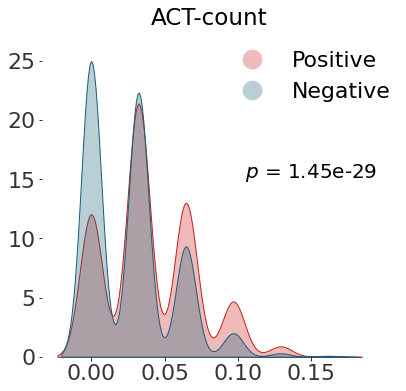

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

# 1 Set fonts
fontsize = 22
font = FontProperties(size=fontsize, weight='light')
black_font_color = '#333'

# 2 Prepare data
# Extract positive and negative sample data
feat_pos_act = dna_sequence_pos['ACT']
feat_neg_act = dna_sequence_neg['ACT']
# Remove NA values
pos_clean = feat_pos_act[~np.isnan(feat_pos_act)]
neg_clean = feat_neg_act[~np.isnan(feat_neg_act)]
# p-value
p_value = 1.454599e-29
p_value_text = f"$p$ = {p_value:.2e}"  # Italic p

# 3 KDE visualization
# Create plot
colors = ['#c71e1d', '#15607a']
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(pos_clean, label='Positive', color=colors[0], fill=True, alpha=0.3)
sns.kdeplot(neg_clean, label='Negative', color=colors[1], fill=True, alpha=0.3)
# Set title
ax.set_title('ACT-count', fontsize=fontsize + 1)
# Set x, y label and tick fonts
ax.tick_params(axis='x', labelsize=font.get_size(),
               labelcolor=black_font_color)
ax.tick_params(axis='y', labelsize=font.get_size(),
               labelcolor=black_font_color)
# Remove y-axis and x-axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# Adjust y-axis limit to ensure highest tick is fully displayed
ax.set_ylim(top=ax.get_ylim()[1]*1.05)  # Add 5% top margin
# Add p-value
ax.text(x=1, y=0.6, s=p_value_text, 
        transform=ax.transAxes,  # Use axis relative position
        ha='right', va='top',    # Right-align, top-align
        fontsize=fontsize-2,     # Slightly smaller than title
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))  # Semi-transparent white background
# Remove borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# Custom legend
simple_legend_labels = ["Positive", "Negative"]
custom_lines = [Line2D([0], [0], 
                marker='o', 
                color='w', 
                markerfacecolor=color, 
                markersize=20, 
                linestyle='',
                alpha=0.3) 
                for color in colors]
legend = plt.legend(custom_lines, 
          simple_legend_labels, 
          bbox_to_anchor=[1.1, 1], 
          frameon=False, 
          labelspacing=0.5,
          prop=font)
fig.savefig("../Data/Features/visualization_demo/_plot_result/dna_sequence_act.jpg", dpi=300, bbox_inches='tight')
plt.show()

# 2 RNA level features

## 2.1 RNA sequence

In [ ]:
import pandas as pd
rna_sequence_pos = pd.read_csv("../Data/Features/visualization_demo/RNA_train_pos/Sequence_Features_ifeatureOmega/iFeatureOmega_RNA_alternate.txt", sep='\t')
rna_sequence_pos['label'] = [1] * len(rna_sequence_pos)
rna_sequence_neg = pd.read_csv("../Data/Features/visualization_demo/RNA_train_neg/Sequence_Features_ifeatureOmega/iFeatureOmega_RNA_alternate.txt", sep='\t')
rna_sequence_neg['label'] = [0] * len(rna_sequence_neg)
rna_sequence = pd.concat([rna_sequence_pos, rna_sequence_neg], ignore_index=True)

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ks_2samp
from tqdm import tqdm

def effect_size_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    if s_pooled == 0:
        return np.nan
    return (np.nanmean(x1) - np.nanmean(x2)) / s_pooled

def analyze_features(df, label_col, p_thresh=0.05, d_thresh=0.5):
    pos_df = df[df[label_col] == 1]
    neg_df = df[df[label_col] == 0]
    
    feature_cols = [col for col in df.columns if col != label_col]
    results = []
    
    for feat in tqdm(feature_cols):
        pos_vals = pos_df[feat].dropna().values
        neg_vals = neg_df[feat].dropna().values
        
        if len(pos_vals) < 2 or len(neg_vals) < 2:
            continue
        
        t_stat, p_val = ttest_ind(pos_vals, neg_vals, equal_var=False, nan_policy='omit')
        ks_stat, ks_p = ks_2samp(pos_vals, neg_vals)
        d = effect_size_d(pos_vals, neg_vals)
        
        if (p_val < p_thresh) and (abs(d) > d_thresh):
            results.append({
                'Feature': feat,
                't_stat': round(t_stat, 3),
                'p_val': p_val,
                'KS_stat': round(ks_stat, 3),
                'KS_p': ks_p,
                'Effect_d': round(d, 3)
            })
    
    return pd.DataFrame(results)

result_df = analyze_features(rna_sequence, label_col='label', p_thresh=0.05, d_thresh=0.4)
print(result_df)


100%|██████████| 991/991 [00:03<00:00, 253.22it/s]

   Feature  t_stat         p_val  KS_stat          KS_p  Effect_d
0  NCP_211  10.492  3.357028e-25     0.21  3.345413e-23     0.432


### KDE visualization

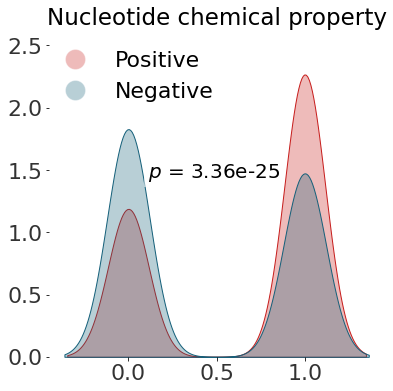

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

# 1 Set fonts
fontsize = 22
font = FontProperties(size=fontsize, weight='light')
black_font_color = '#333'

# 2 Prepare data
# Extract positive and negative sample data
feat_pos = rna_sequence_pos['NCP_211']
feat_neg = rna_sequence_neg['NCP_211']
# Remove NA values
pos_clean = feat_pos[~np.isnan(feat_pos)]
neg_clean = feat_neg[~np.isnan(feat_neg)]
# p-value
p_value = 3.357028e-25 
p_value_text = f"$p$ = {p_value:.2e}"  # Italic p

# 3 KDE visualization
# Create plot
colors = ['#c71e1d', '#15607a']
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(pos_clean, label='Positive', color=colors[0], fill=True, alpha=0.3)
sns.kdeplot(neg_clean, label='Negative', color=colors[1], fill=True, alpha=0.3)
# Set title
ax.set_title('Nucleotide chemical property', fontsize=fontsize + 1)
# Set x, y label and tick fonts
ax.tick_params(axis='x', labelsize=font.get_size(),
               labelcolor=black_font_color)
ax.tick_params(axis='y', labelsize=font.get_size(),
               labelcolor=black_font_color)
# Remove axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# Adjust y-axis limit to ensure highest tick is fully displayed
ax.set_ylim(top=ax.get_ylim()[1]*1.1)  # Add 10% top margin
# Add p-value
ax.text(x=0.69, y=0.6, s=p_value_text, 
        transform=ax.transAxes,  # Use axis relative position
        ha='right', va='top',    # Right-align, top-align
        fontsize=fontsize-2,     # Slightly smaller than title
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))  # Semi-transparent white background
# Remove borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# Custom legend
simple_legend_labels = ["Positive", "Negative"]
custom_lines = [Line2D([0], [0], 
                marker='o', 
                color='w', 
                markerfacecolor=color, 
                markersize=20, 
                linestyle='',
                alpha=0.3) 
                for color in colors]
legend = plt.legend(custom_lines, 
          simple_legend_labels, 
          bbox_to_anchor=[0.55, 1], 
          frameon=False, 
          labelspacing=0.5,
          prop=font)
fig.savefig("../Data/Features/visualization_demo/_plot_result/rna_sequence_ncp.jpg", dpi=300, bbox_inches='tight')
plt.show()

## 2.2 RNA structure

In [ ]:
from Bio import SeqIO
import re
import pandas as pd

def retrieve_mfe(input_file, mfe_column_name):
    # Read FASTA file
    id_list = []
    mfe_list = []
    for record in SeqIO.parse(input_file, "fasta"):
        id_list.append(str(record.id))
        match = re.search(r"[-+]?\d*\.\d+", str(record.seq))
        mfe_list.append(float(match.group(0)))
    df = pd.DataFrame({"variant_hg38": id_list, mfe_column_name: mfe_list})
    return df

def retrieve_delta_mfe(ref_input_file, alt_input_file):
    ref_neg_df = retrieve_mfe(ref_input_file, "ref_mfe")
    alt_neg_df = retrieve_mfe(alt_input_file, "alt_mfe")
    df = ref_neg_df.merge(alt_neg_df, how='left', left_on='variant_hg38', right_on='variant_hg38', suffixes=('', '_m'))
    df['delta_mfe'] = df['alt_mfe'] - df['ref_mfe']
    return df

# Specify the paths to FASTA files
neg_ref_fasta_file = "../Data/Features/visualization_demo/RNA_train_neg/RNA_Structure_Features_RNAfold/RNAfold.ref.out.fasta"
neg_alt_fasta_file = "../Data/Features/visualization_demo/RNA_train_neg/RNA_Structure_Features_RNAfold/RNAfold.alt.out.fasta"
neg_df = retrieve_delta_mfe(neg_ref_fasta_file, neg_alt_fasta_file)
pos_ref_fasta_file = "../Data/Features/visualization_demo/RNA_train_pos/RNA_Structure_Features_RNAfold/RNAfold.ref.out.fasta"
pos_alt_fasta_file = "../Data/Features/visualization_demo/RNA_train_pos/RNA_Structure_Features_RNAfold/RNAfold.alt.out.fasta"
pos_df = retrieve_delta_mfe(pos_ref_fasta_file, pos_alt_fasta_file)

In [20]:
neg_df['label'] = [0] * len(neg_df)
pos_df['label'] = [1] * len(pos_df)
mrna_df = pd.concat([neg_df, pos_df], ignore_index=True)
result_df = analyze_features(mrna_df.iloc[:, 1:], label_col='label', p_thresh=0.05, d_thresh=0)
print(result_df)

100%|██████████| 3/3 [00:00<00:00, 270.59it/s]

     Feature  t_stat     p_val  KS_stat      KS_p  Effect_d
0  delta_mfe   3.062  0.002225    0.071  0.005072     0.126


### KDE visualization

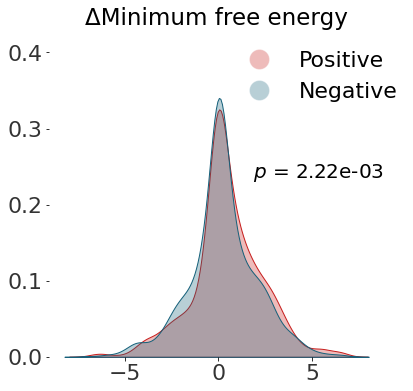

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

# 1 Set fonts
fontsize = 22
font = FontProperties(size=fontsize, weight='light')
black_font_color = '#333'

# 2 Prepare data
# Extract positive and negative sample data
feat_pos = pos_df['delta_mfe']
feat_neg = neg_df['delta_mfe']
# Remove NA values
pos_clean = feat_pos[~np.isnan(feat_pos)]
neg_clean = feat_neg[~np.isnan(feat_neg)]
# p-value
p_value = 0.002225
p_value_text = f"$p$ = {p_value:.2e}"  # Italic p

# 3 KDE visualization
# Create plot
colors = ['#c71e1d', '#15607a']
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(pos_clean, label='Positive', color=colors[0], fill=True, alpha=0.3)
sns.kdeplot(neg_clean, label='Negative', color=colors[1], fill=True, alpha=0.3)
# Set title
ax.set_title('ΔMinimum free energy', fontsize=fontsize + 1)
# Set x, y label and tick fonts
ax.tick_params(axis='x', labelsize=font.get_size(),
               labelcolor=black_font_color)
ax.tick_params(axis='y', labelsize=font.get_size(),
               labelcolor=black_font_color)
# Remove axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# Adjust y-axis limit to ensure highest tick is fully displayed
ax.set_ylim(top=ax.get_ylim()[1]*1.2)  # Add 20% top margin
# Add p-value
ax.text(x=1, y=0.6, s=p_value_text, 
        transform=ax.transAxes,  # Use axis relative position
        ha='right', va='top',    # Right-align, top-align
        fontsize=fontsize-2,     # Slightly smaller than title
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))  # Semi-transparent white background
# Remove borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# Custom legend
simple_legend_labels = ["Positive", "Negative"]
custom_lines = [Line2D([0], [0], 
                marker='o', 
                color='w', 
                markerfacecolor=color, 
                markersize=20, 
                linestyle='',
                alpha=0.3) 
                for color in colors]
legend = plt.legend(custom_lines, 
          simple_legend_labels, 
          bbox_to_anchor=[1.1, 1], 
          frameon=False, 
          labelspacing=0.5,
          prop=font)
fig.savefig("../Data/Features/visualization_demo/_plot_result/rna_structure_dmfe.jpg", dpi=300, bbox_inches='tight')
plt.show()

# 3 Protein level features

## 3.1 Protein sequence

In [ ]:
import pandas as pd
protein_sequence_pos = pd.read_csv("../Data/Features/visualization_demo/Protein_train_pos/Sequence_Features_ifeatureOmega/iFeatureOmega_Protein_reference.txt", sep='\t')
protein_sequence_pos['label'] = [1] * len(protein_sequence_pos)
protein_sequence_neg = pd.read_csv("../Data/Features/visualization_demo/Protein_train_neg/Sequence_Features_ifeatureOmega/iFeatureOmega_Protein_reference.txt", sep='\t')
protein_sequence_neg['label'] = [0] * len(protein_sequence_pos)
protein_sequence = pd.concat([protein_sequence_pos, protein_sequence_neg], ignore_index=True)

In [24]:
result_df = analyze_features(protein_sequence, label_col='label', p_thresh=0.05, d_thresh=0.1)

100%|██████████| 2686/2686 [00:07<00:00, 343.37it/s] 


### 3.1.1 Statistics

In [25]:
result_df.sort_values(by='p_val')

,Feature,t_stat,p_val,KS_stat,KS_p,Effect_d
4,type3B_T1.G.1_T1.G.2_gap2,-3.827,0.000133,0.057,0.044676,-0.157
20,type13_T1.G.3_T1.G.2_gap2,-3.551,0.000392,0.045,0.185273,-0.146
9,type6B_T1.G.4_T1.G.2_gap2,-3.468,0.000534,0.041,0.283565,-0.143
15,type9_T1.G.1_T1.G.2_gap2,3.378,0.000742,0.066,0.011563,0.139
3,type3A_T1.G.1_T1.G.2_gap2,-3.299,0.000987,0.033,0.540331,-0.136
8,type5_T1.G.1_T1.G.3_gap2,3.205,0.001370,0.068,0.008846,0.132
10,type6B_T1.G.5_T1.G.1_gap2,3.146,0.001676,0.041,0.261366,0.129
12,type6C_T1.G.3_T1.G.3_gap2,3.062,0.002222,0.061,0.024792,0.126
13,type8_T1.G.1_T1.G.2_gap2,-2.979,0.002926,0.049,0.115855,-0.123
7,type4_T1.G.5_T1.G.3_gap2,2.958,0.003129,0.055,0.055875,0.122


### 3.1.2 KDE visualization

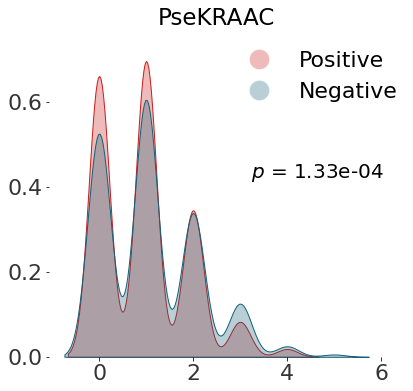

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

# 1 Set fonts
fontsize = 22
font = FontProperties(size=fontsize, weight='light')
black_font_color = '#333'

# 2 Prepare data
# Extract positive and negative sample data
feat_pos = protein_sequence_pos['type3B_T1.G.1_T1.G.2_gap2']
feat_neg = protein_sequence_neg['type3B_T1.G.1_T1.G.2_gap2']
# Remove NA values
pos_clean = feat_pos[~np.isnan(feat_pos)]
neg_clean = feat_neg[~np.isnan(feat_neg)]
# p-value
p_value = 0.000133
p_value_text = f"$p$ = {p_value:.2e}"  # Italic p

# 3 KDE visualization
# Create plot
colors = ['#c71e1d', '#15607a']
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(pos_clean, label='Positive', color=colors[0], fill=True, alpha=0.3)
sns.kdeplot(neg_clean, label='Negative', color=colors[1], fill=True, alpha=0.3)
# Set title
ax.set_title('PseKRAAC', fontsize=fontsize + 1)
# Set x, y label and tick fonts
ax.tick_params(axis='x', labelsize=font.get_size(),
               labelcolor=black_font_color)
ax.tick_params(axis='y', labelsize=font.get_size(),
               labelcolor=black_font_color)
# Remove axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# Adjust y-axis limit to ensure highest tick is fully displayed
ax.set_ylim(top=ax.get_ylim()[1]*1.05)  # Add 5% top margin
# Add p-value
ax.text(x=1, y=0.6, s=p_value_text, 
        transform=ax.transAxes,  # Use axis relative position
        ha='right', va='top',    # Right-align, top-align
        fontsize=fontsize-2,     # Slightly smaller than title
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))  # Semi-transparent white background
# Remove borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# Custom legend
simple_legend_labels = ["Positive", "Negative"]
custom_lines = [Line2D([0], [0], 
                marker='o', 
                color='w', 
                markerfacecolor=color, 
                markersize=20, 
                linestyle='',
                alpha=0.3) 
                for color in colors]
legend = plt.legend(custom_lines, 
          simple_legend_labels, 
          bbox_to_anchor=[1.1, 1], 
          frameon=False, 
          labelspacing=0.5,
          prop=font)
fig.savefig("../Data/Features/visualization_demo/_plot_result/protein_sequence_psekraac.jpg", dpi=300, bbox_inches='tight')
plt.show()

## 3.2 IDR

In [ ]:
import pandas as pd

def parse_aiupred(file_path):
    data = {}
    with open(file_path, 'r') as f:
        current_id = None
        current_values = []
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            if line.startswith('>'):
                if current_id is not None:
                    data[current_id] = current_values
                current_id = line[1:]  # Remove >
                current_values = []
            else:
                parts = line.split()
                if len(parts) == 3:
                    value = float(parts[2])
                    current_values.append(value)
        if current_id is not None:
            data[current_id] = current_values  # Add the last entry

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(data, orient='index')
    df.index.name = 'ID'
    df.reset_index(inplace=True)

    # TODO Calculate mean, std, median for [:, 1:] as new three columns
    value_cols = df.columns[1:]  # Residue columns
    df['IDR_mean'] = df[value_cols].mean(axis=1, skipna=True)
    df['IDR_std'] = df[value_cols].std(axis=1, skipna=True)
    df['IDR_median'] = df[value_cols].median(axis=1, skipna=True)
    return df

# Usage
df_idr = parse_aiupred('../Data/Features/visualization_demo/Protein_train_pos/aiupred.output')

In [ ]:
df_idr_pos = parse_aiupred('../Data/Features/visualization_demo/Protein_train_pos/aiupred.output')
df_idr_pos['label'] = [1] * len(df_idr_pos)
df_idr_neg = parse_aiupred('../Data/Features/visualization_demo/Protein_train_neg/aiupred.output')
df_idr_neg['label'] = [0] * len(df_idr_neg)
df_idr_result = pd.concat([df_idr_pos, df_idr_neg], ignore_index=True)
df_idr_result

,ID,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,IDR_mean,IDR_std,IDR_median,label
0,5_37020877_G/A;ENST00000282516;5328;1,0.2573,0.2317,0.2369,0.2407,0.2339,0.2214,0.2278,0.2253,0.2180,...,0.2582,0.2353,0.2182,0.2100,0.2104,0.2147,0.238314,0.023943,0.2339,1
1,10_102830966_C/T;ENST00000639393;1266;-1,0.7883,0.7391,0.6951,0.6793,0.6911,0.7157,0.7234,0.7221,0.7185,...,0.7208,0.7100,0.7080,0.7186,0.7361,0.7401,0.721529,0.021988,0.7208,1
2,10_121517371_C/T;ENST00000358487;1032;-1,0.2399,0.2173,0.2279,0.2355,0.2275,0.2071,0.1893,0.1815,0.1830,...,0.2297,0.2447,0.2587,0.2606,0.2369,0.1718,0.219619,0.024196,0.2248,1
3,2_32114825_G/A;ENST00000315285;870;1,0.9847,0.9853,0.9872,0.9889,0.9899,0.9902,0.9901,0.9906,0.9906,...,0.9838,0.9821,0.9815,0.9819,0.9818,0.9779,0.986567,0.003820,0.9873,1
4,9_97441875_G/A;ENST00000355295;855;1,0.5448,0.5806,0.5463,0.5022,0.4765,0.4747,0.4859,0.5099,0.5208,...,0.6834,0.6594,0.6462,0.6497,0.6511,0.5939,0.588971,0.074499,0.5939,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,16_56519752_C/A;ENST00000245157;111;-1,0.3704,0.3649,0.3471,0.3399,0.3486,0.3670,0.3768,0.3851,0.3954,...,0.3905,0.4346,0.4847,0.5253,0.5364,0.4928,0.401024,0.058629,0.3826,0
2358,3_48572139_C/A;ENST00000328333;7011;-1,0.9823,0.9813,0.9841,0.9871,0.9890,0.9897,0.9904,0.9912,0.9915,...,0.9864,0.9860,0.9850,0.9831,0.9812,0.9815,0.987138,0.003736,0.9872,0
2359,19_18075801_C/A;ENST00000593993;648;-1,0.8870,0.8368,0.8216,0.8229,0.8306,0.8403,0.8509,0.8656,0.8695,...,0.8602,0.8641,0.8637,0.8587,0.8531,0.8558,0.854148,0.016529,0.8580,0
2360,17_75522323_C/T;ENST00000545228;333;1,0.7068,0.7248,0.7623,0.7844,0.7834,0.7684,0.7663,0.7656,0.7646,...,0.6446,0.6110,0.5967,0.6067,0.6375,0.6739,0.716352,0.063338,0.7414,0


### 3.2.1 Statistics

In [29]:
result_df = analyze_features(df_idr_result.iloc[:, 1:], label_col='label', p_thresh=0.1, d_thresh=0)

100%|██████████| 24/24 [00:00<00:00, 221.66it/s]


### 3.2.2 KDE Visualization

## 3.3 Secondary


- Column 1: Class assignment - B for buried or E for Exposed - Threshold: 25% exposure, but not -ased on RSA
- Column 2: Amino acid
- Column 3: Sequence name
- Column 4: Amino acid number
- Column 5: Relative Surface Accessibility - RSA
- Column 6: Absolute Surface Accessibility
- Column 7: Not used
- Column 8: Probability for Alpha-Helix
- Column 9: Probability for Beta-strand
- Column 10: Probability for Coil


### 3.3.1 Based on averge residue

In [30]:
# Calculate aggregated statistics based on residues
def retrieve_netsurf_agg(input_file):
    df = pd.read_csv(input_file, sep='\t', comment='#', header=None)
    df.columns = ['solvent_accessibility', 'amino_acid', 'variant_hg38', 'amino_acid_number',
                'rsa', 'asa', 'not_used', 'p_alpha_helix', 'p_beta_strand', 'p_coil']
    # Replace solvent_accessibility: E->0, B->1
    df['solvent_accessibility_num'] = df['solvent_accessibility'].map({'E': 0, 'B': 1})
    # Columns for statistical calculation
    feature_cols = ['solvent_accessibility_num', 'rsa', 'asa', 'not_used', 
                    'p_alpha_helix', 'p_beta_strand', 'p_coil']
    # Calculate mean and std by grouping
    agg_funcs = {}
    for col in feature_cols:
        agg_funcs[col + '_mean'] = (col, 'mean')
        agg_funcs[col + '_std'] = (col, 'std')
    grouped_df = df.groupby('variant_hg38').agg(**agg_funcs).reset_index()
    return grouped_df

In [ ]:
pos_df = retrieve_netsurf_agg("../Data/Features/visualization_demo/Protein_train_pos/netsurfp3/default_user/default_user.netsurfp.txt")
pos_df['label'] = [1] * len(pos_df)
neg_df = retrieve_netsurf_agg("../Data/Features/visualization_demo/Protein_train_neg/netsurfp3/default_user/default_user.netsurfp.txt")
neg_df['label'] = [0] * len(neg_df)
df = pd.concat([pos_df, neg_df], ignore_index=True)
df.head()

,variant_hg38,solvent_accessibility_num_mean,solvent_accessibility_num_std,rsa_mean,rsa_std,asa_mean,asa_std,not_used_mean,not_used_std,p_alpha_helix_mean,p_alpha_helix_std,p_beta_strand_mean,p_beta_strand_std,p_coil_mean,p_coil_std,label
0,10_100950753_GAENST0000037026933301,0.000000,0.000000,0.489987,0.130469,89.469082,30.984743,0.0,0.0,0.129242,0.062120,0.135113,0.089311,0.735645,0.144473,1
1,10_100989687_CTENST0000031191612871,0.095238,0.300793,0.509371,0.179075,92.103182,34.932243,0.0,0.0,0.474781,0.320044,0.008663,0.007235,0.516556,0.318224,1
2,10_102830966_CTENST000006393931266-1,0.000000,0.000000,0.603531,0.111439,112.977733,29.832582,0.0,0.0,0.092720,0.077445,0.044721,0.042574,0.862559,0.089501,1
3,10_104037646_GAENST000006480763198-1,0.000000,0.000000,0.519769,0.157707,96.572395,38.384516,0.0,0.0,0.514002,0.323718,0.024819,0.021200,0.461179,0.315584,1
4,10_104037688_GAENST000006480763156-1,0.000000,0.000000,0.593669,0.115398,99.967356,21.991929,0.0,0.0,0.071977,0.087046,0.086657,0.068117,0.841366,0.106429,1


### 3.3.2 Average residue statistics

In [32]:
result_df = analyze_features(df.iloc[:, 1:], label_col='label', p_thresh=0.05, d_thresh=0)

100%|██████████| 14/14 [00:00<00:00, 345.84it/s]


### 3.3.3 Based on single residue

In [33]:
# Calculate based on individual residues
def retrieve_netsurf(input_file):
    # Read data
    df = pd.read_csv(input_file, 
                    sep='\t', header=None, comment='#')
    df.columns = ['solvent_accessibility', 'amino_acid', 'variant_hg38', 'amino_acid_number',
                'rsa', 'asa', 'not_used', 'p_alpha_helix', 'p_beta_strand', 'p_coil']
    # Replace solvent_accessibility: E->0, B->1
    df['solvent_accessibility_num'] = df['solvent_accessibility'].map({'E': 0, 'B': 1})
    # Verify each variant_hg38 has the same number of residues
    counts = df.groupby('variant_hg38').size()
    assert counts.nunique() == 1, "Number of amino_acid entries per variant_hg38 is inconsistent!"
    
    # Get fixed window size
    window_size = counts.iloc[0]
    # Select columns to be expanded
    expand_cols = ['solvent_accessibility_num', 'rsa', 'asa', 'p_alpha_helix', 'p_beta_strand', 'p_coil']
    # Group and expand
    expanded_data = []
    
    for variant, group in df.groupby('variant_hg38'):
        group = group.sort_values('amino_acid_number')  # Ensure consistent ordering
        row = {'variant_hg38': variant}
        for i, (_, r) in enumerate(group.iterrows(), 1):
            for col in expand_cols:
                row[f"{col}_{i}"] = r[col]
        expanded_data.append(row)
    wide_df = pd.DataFrame(expanded_data)
    print(wide_df.head())
    return wide_df

### 3.3.4 Single residue statistics

In [ ]:
import pandas as pd
pos_df = retrieve_netsurf("../Data/Features/visualization_demo/Protein_train_pos/netsurfp3/default_user/default_user.netsurfp.txt")
pos_df['label'] = [1] * len(pos_df)
neg_df = retrieve_netsurf("../Data/Features/visualization_demo/Protein_train_neg/netsurfp3/default_user/default_user.netsurfp.txt")
neg_df['label'] = [0] * len(neg_df)
df = pd.concat([pos_df, neg_df], ignore_index=True)

                           variant_hg38  solvent_accessibility_num_1  \
0   10_100950753_GAENST0000037026933301                            0   
1   10_100989687_CTENST0000031191612871                            0   
2  10_102830966_CTENST000006393931266-1                            0   
3  10_104037646_GAENST000006480763198-1                            0   
4  10_104037688_GAENST000006480763156-1                            0   

      rsa_1       asa_1  p_alpha_helix_1  p_beta_strand_1  p_coil_1  \
0  0.609068   94.405481         0.069012         0.068996  0.861992   
1  0.853823  132.342621         0.001225         0.000262  0.998513   
2  0.806042  181.359413         0.003669         0.003771  0.992561   
3  0.819454  158.154602         0.012775         0.001959  0.985266   
4  0.816848   84.952221         0.000188         0.001717  0.998095   

   solvent_accessibility_num_2     rsa_2       asa_2  ...      asa_20  \
0                            0  0.416331   69.527336  ...   79.2013

In [35]:
result_df = analyze_features(df.iloc[:, 1:], label_col='label', p_thresh=0.05, d_thresh=0)

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:00<00:00, 374.97it/s]


### 3.3.5 KDE visualization

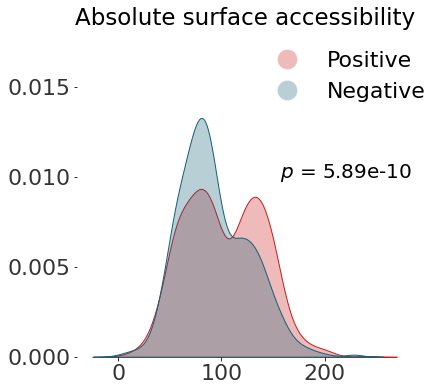

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

# 1 Set fonts
fontsize = 22
font = FontProperties(size=fontsize, weight='light')
black_font_color = '#333'

# 2 Prepare data
# Extract positive and negative sample data
feat_pos = pos_df['asa_11']
feat_neg = neg_df['asa_11']
# Remove NA values
pos_clean = feat_pos[~np.isnan(feat_pos)]
neg_clean = feat_neg[~np.isnan(feat_neg)]
# p-value
p_value = 5.885413e-10
p_value_text = f"$p$ = {p_value:.2e}"  # Italic p

# 3 KDE visualization
# Create plot
colors = ['#c71e1d', '#15607a']
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(pos_clean, label='Positive', color=colors[0], fill=True, alpha=0.3)
sns.kdeplot(neg_clean, label='Negative', color=colors[1], fill=True, alpha=0.3)
# Set title
ax.set_title('Absolute surface accessibility', fontsize=fontsize + 1)
# Set x, y label and tick fonts
ax.tick_params(axis='x', labelsize=font.get_size(),
               labelcolor=black_font_color)
ax.tick_params(axis='y', labelsize=font.get_size(),
               labelcolor=black_font_color)
# Add p-value
ax.text(x=1, y=0.6, s=p_value_text, 
        transform=ax.transAxes,  # Use axis relative position
        ha='right', va='top',    # Right-align, top-align
        fontsize=fontsize-2,     # Slightly smaller than title
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))  # Semi-transparent white background
# Remove axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# Adjust y-axis limit to ensure highest tick is fully displayed
ax.set_ylim(top=ax.get_ylim()[1]*1.3)  # Add 30% top margin
# Remove borders
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# Custom legend
simple_legend_labels = ["Positive", "Negative"]
custom_lines = [Line2D([0], [0], 
                marker='o', 
                color='w', 
                markerfacecolor=color, 
                markersize=20, 
                linestyle='',
                alpha=0.3) 
                for color in colors]
legend = plt.legend(custom_lines, 
          simple_legend_labels, 
          bbox_to_anchor=[1.1, 1], 
          frameon=False, 
          labelspacing=0.5,
          prop=font)
fig.savefig("../Data/Features/visualization_demo/_plot_result/protein_structure_asa.jpg", dpi=300, bbox_inches='tight')
plt.show()

# 4 LLM features

## 4.1 load meta informations

In [ ]:
import pandas as pd

meta_info = pd.read_csv("../Data/Features/visualization_demo/llms_features/train_2362.txt", sep='\t', usecols=['variant_hg38', 'label'])
meta_info.head()

,variant_hg38,label
0,10_100972951_C/T,0
1,10_100989672_C/T,0
2,10_102830963_C/T,0
3,10_104037655_G/A,0
4,10_104037685_C/T,0


## 4.2 Draw umap

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import torch


def draw_umap(X0, y0, title, savepath):
	reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
	X_umap = reducer.fit_transform(X0)
	# set color and label
	colors = ['#1d81a2', '#c71e1d']  # Benign: #1d81a2, Pathogenic: #c71e1d
	labels = ['Benign', 'Pathogenic']

	plt.figure(figsize=(4, 4))

	# plot scatter
	plt.scatter(X_umap[y0==0, 0], X_umap[y0==0, 1], alpha=0.5, label=labels[0], color=colors[0], s=10)
	plt.scatter(X_umap[y0==1, 0], X_umap[y0==1, 1], alpha=0.5, label=labels[1], color=colors[1], s=10)

	# set legend and title
	plt.legend(ncol=2, loc='upper center', fontsize=12)
	plt.title(title, fontsize=14)

	plt.tight_layout()
	plt.savefig(savepath, dpi=300, bbox_inches='tight')
	plt.show()


def plot_umap_single(X, y, title, n_neighbors=15, labels_text=['Benign', 'Pathogenic'], min_dist=0.1, savepath=None):
	reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
	X_umap = reducer.fit_transform(X)

	plt.figure(figsize=(4, 4))
	plt.scatter(X_umap[y==0,0], X_umap[y==0,1], alpha=0.5, label=labels_text[0], color=colors[0], s=10)
	plt.scatter(X_umap[y==1,0], X_umap[y==1,1], alpha=0.5, label=labels_text[1], color=colors[1], s=10)
	
	plt.legend(ncol=2, loc='upper center', fontsize=12)
	plt.title(title, fontsize=14)
	plt.tight_layout()
	plt.savefig(savepath, dpi=300, bbox_inches='tight')
	plt.show()

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4.3 RNA-SpliceBERT

In [ ]:
path = "../Data/Features/visualization_demo/llms_features/train-SpliceBERT-RNA.pth"
data = torch.load(path)

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


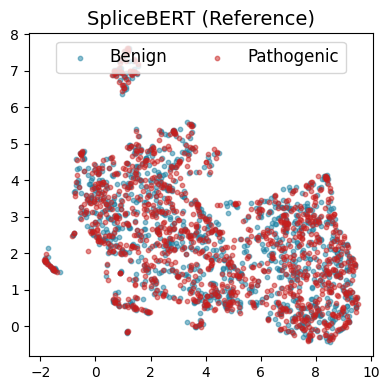

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


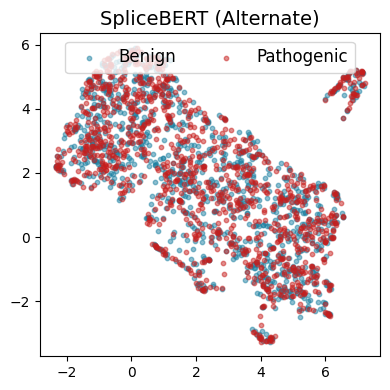

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


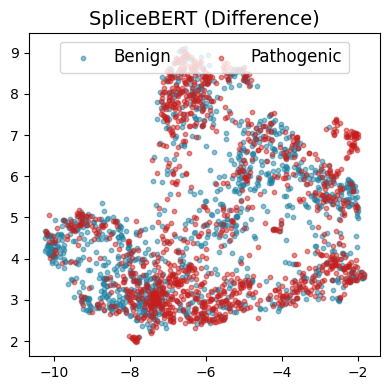

In [ ]:
X0_ref = []
X0_alt = []
X0_diff = []
y0 = []
for vid, feats in data.items():
	if vid not in set(meta_info['variant_hg38']):
		continue
	ref_feat = feats['ref_splicebert'].mean(0).numpy()
	alt_feat = feats['alt_splicebert'].mean(0).numpy()
	diff_feat = alt_feat - ref_feat
	X0_ref.append(ref_feat)
	X0_alt.append(alt_feat)
	X0_diff.append(diff_feat)
	y0.append(meta_info.loc[meta_info['variant_hg38']==vid, 'label'].values[0])

X0_ref = np.array(X0_ref)
X0_alt = np.array(X0_alt)
X0_diff = np.array(X0_diff)
y0 = np.array(y0)

draw_umap(X0_ref, y0, "SpliceBERT (Reference)", "../Data/Features/visualization_demo/_plot_result/SpliceBERT_Reference.jpg")
draw_umap(X0_alt, y0, "SpliceBERT (Alternate)", "../Data/Features/visualization_demo/_plot_result/SpliceBERT_Alternate.jpg")
draw_umap(X0_diff, y0, "SpliceBERT (Difference)", "../Data/Features/visualization_demo/_plot_result/SpliceBERT_Difference.jpg")

## 4.4 DNA-GPN-MSA| Protein-ISM | RNA-CaLM

In [ ]:
path = "../Data/Features/visualization_demo/llms_features/train_with_biological.pt"
data_gic = torch.load(path)

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


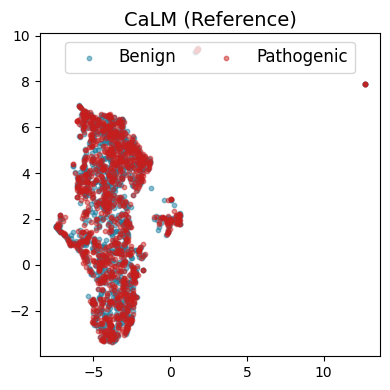

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


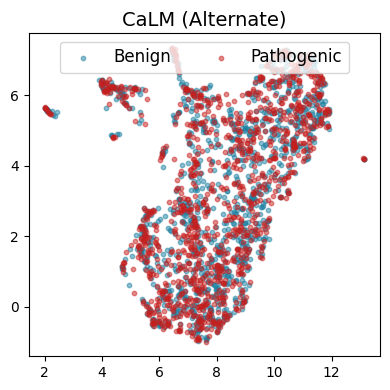

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


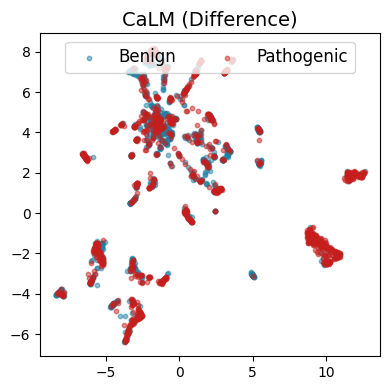

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


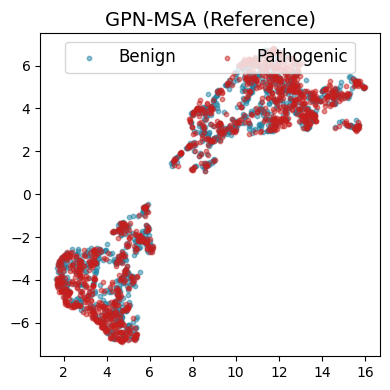

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


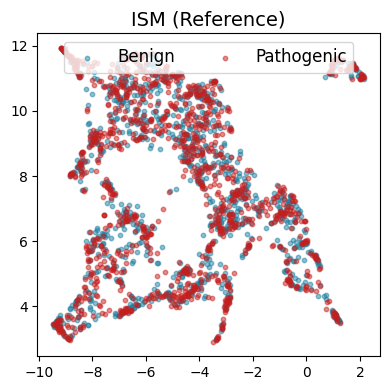

In [ ]:
vids = list(data_gic.keys())
labels = np.array([data_gic[v]["label"] for v in vids])

def to_numpy(x):
	if hasattr(x, "detach"):
		return x.detach().cpu().numpy()
	return np.array(x)

calm_ref = np.array([to_numpy(data_gic[v]["calm_ref"]).mean(0) for v in vids])
calm_alt = np.array([to_numpy(data_gic[v]["calm_alt"]).mean(0) for v in vids])
calm_diff = calm_alt - calm_ref
gpn = np.array([to_numpy(data_gic[v]["gpn_feature"]).mean(0) for v in vids])
ism = np.array([to_numpy(data_gic[v]["ism_feature"]).mean(0) for v in vids])

feature_dict = {
	"CaLM (Reference)": calm_ref,
	"CaLM (Alternate)": calm_alt,
	"CaLM (Difference)": calm_diff,
	"GPN-MSA (Reference)": gpn,
	"ISM (Reference)": ism
}

# color and label
colors = ['#1d81a2', '#c71e1d']  # Benign / Pathogenic
labels_text = ['Benign', 'Pathogenic']
# plot
for name, X in feature_dict.items():
	plot_umap_single(X, labels, name, n_neighbors=15, labels_text=['Benign', 'Pathogenic'], min_dist=0.1, savepath=f'../Data/Features/visualization_demo/_plot_result/{name.replace("(", "").replace(")", "")}.jpg')

## 4.5 RNA-ERNIE

### A) CLS

cls, use the cls token to represent the sequence feature.

In [ ]:
path = "../Data/Features/visualization_demo/llms_features/ERINE-RNA-last-hidden.pth"
data_ernie = torch.load(path, weights_only=False)

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


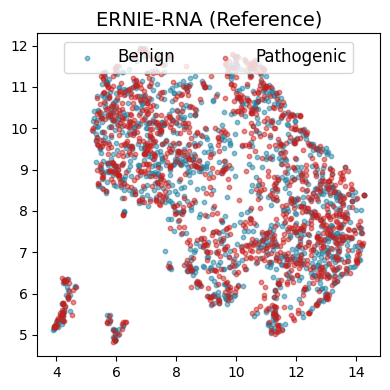

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


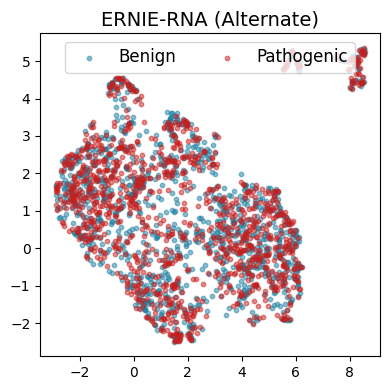

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


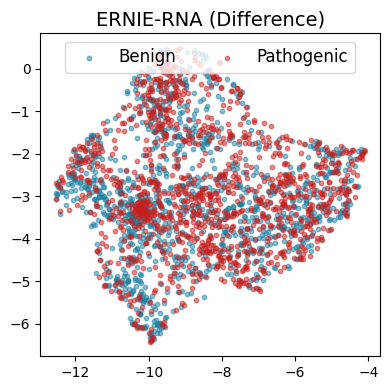

In [ ]:
X0_ernie_ref = []
X0_ernie_alt = []
X0_ernie_diff = []
y0 = []
for vid, feats in data_ernie.items():
	if vid not in set(meta_info['variant_hg38']):
		continue
	ref_feat = feats['ref_ernie_rna_cls']
	alt_feat = feats['alt_ernie_rna_cls']
	diff_feat = alt_feat - ref_feat
	X0_ernie_ref.append(ref_feat)
	X0_ernie_alt.append(alt_feat)
	X0_ernie_diff.append(diff_feat)
	y0.append(meta_info.loc[meta_info['variant_hg38']==vid, 'label'].values[0])

X0_ernie_ref = np.array(X0_ernie_ref)
X0_ernie_alt = np.array(X0_ernie_alt)
X0_ernie_diff = np.array(X0_ernie_diff)
y0 = np.array(y0)
draw_umap(X0_ernie_ref, y0, "ERNIE-RNA (Reference)", "../Data/Features/visualization_demo/_plot_result/ERNIE-RNA_Reference.jpg")
draw_umap(X0_ernie_alt, y0, "ERNIE-RNA (Alternate)","../Data/Features/visualization_demo/_plot_result/ERNIE-RNA_Alternate.jpg")
draw_umap(X0_ernie_diff, y0, "ERNIE-RNA (Difference)","../Data/Features/visualization_demo/_plot_result/ERNIE-RNA_Difference.jpg")

### B) All

All, use all tokens to represent the feature.

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


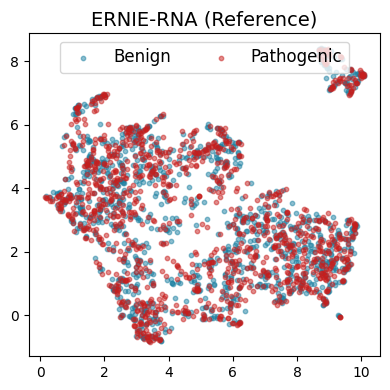

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


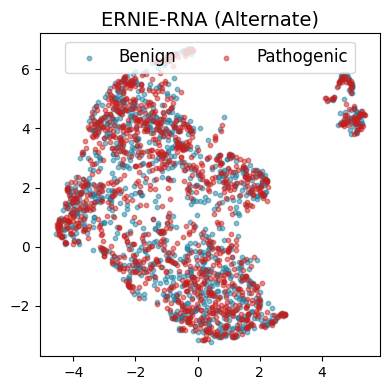

/data1/yechen/miniconda3/envs/ism/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


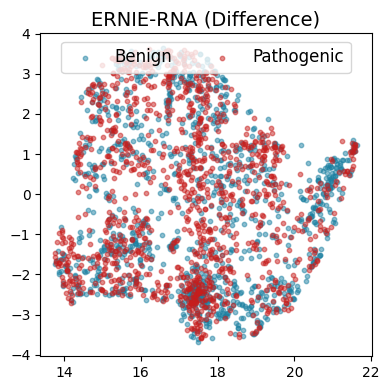

In [ ]:
import numpy as np

X0_ernie_ref = []
X0_ernie_alt = []
X0_ernie_diff = []
y0 = []
for vid, feats in data_ernie.items():
	if vid not in set(meta_info['variant_hg38']):
		continue
	ref_feat = feats['ref_ernie_rna_all'].mean(0)
	alt_feat = feats['alt_ernie_rna_all'].mean(0)
	diff_feat = alt_feat - ref_feat
	X0_ernie_ref.append(ref_feat)
	X0_ernie_alt.append(alt_feat)
	X0_ernie_diff.append(diff_feat)
	y0.append(meta_info.loc[meta_info['variant_hg38']==vid, 'label'].values[0])

X0_ernie_ref = np.array(X0_ernie_ref)
X0_ernie_alt = np.array(X0_ernie_alt)
X0_ernie_diff = np.array(X0_ernie_diff)
y0 = np.array(y0)

draw_umap(X0_ernie_ref, y0, "ERNIE-RNA (Reference)", "../Data/Features/visualization_demo/_plot_result/ERNIE-RNA_All_Reference.jpg")
draw_umap(X0_ernie_alt, y0, "ERNIE-RNA (Alternate)", "../Data/Features/visualization_demo/_plot_result/ERNIE-RNA_All_Alternate.jpg")
draw_umap(X0_ernie_diff, y0, "ERNIE-RNA (Difference)", "../Data/Features/visualization_demo/_plot_result/ERNIE-RNA_All_Difference.jpg")